In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

#TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

2025-04-01 19:30:43.739230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-01 19:30:43.739258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-01 19:30:43.740463: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 19:30:43.746880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-01 19:30:44.330813: W tensorflow/compiler/tf2

In [2]:
# Load dataset
def load_dataset(dir_path):
    """
    Load dataset from a given directory path.
    
    Args:
        dir_path (str): Path to the dataset directory.
    
    Returns:
        tuple: A tuple containing:
            - training_dataset (np.array): Array of training data.
            - testing_dataset (np.array): Array of testing data.
            - label_train (pd.DataFrame): DataFrame of training labels.
            - label_test (pd.DataFrame): DataFrame of testing labels.
    """
    
    train_path = os.path.join(dir_path, 'Train')
    test_path = os.path.join(dir_path, 'Test')
    
    label_training = os.path.join(dir_path, 'label_train.csv')
    label_testing = os.path.join(dir_path, 'test_format.csv')
    
    training_files = os.listdir(train_path)
    testing_files = os.listdir(test_path)
    
    # Load training and testing datasets
    training_dataset = []
    for path in training_files:
        if path.endswith('.npy'):
            train_data = np.load(os.path.join(train_path, path))
            training_dataset.append(train_data)
            
    testing_dataset = []
    for path in testing_files:
        if path.endswith('.npy'):
            test_data = np.load(os.path.join(test_path, path))
            testing_dataset.append(test_data)
    
    # Load labels
    label_train = pd.read_csv(label_training)
    label_test = pd.read_csv(label_testing)
    
    
    return np.array(training_dataset), np.array(testing_dataset), label_train, label_test

In [3]:
train, test, train_labels, test_labels = load_dataset('Dataset/')

# Plot animaition af the testing data
print(test[1].shape)
print(test_labels.shape)

# Normalize the data and convert from negative to positive
train = train - np.min(train)
train = train.astype('float32') / max(np.max(train), 1)
test = test - np.min(test)
test = test.astype('float32') / max(np.max(test), 1)

train_labels_coded = pd.get_dummies(train_labels['target'])
test_labels_coded = pd.get_dummies(test_labels['target'])
# Add two missing columns to the test_labels
test_labels_coded['1'] = False
test_labels_coded['2'] = False

(72, 48)
(60, 2)


In [4]:
# Creating a model

model = Sequential([
    InputLayer(input_shape=(72, 48, 1)),
    Conv2D(32, (6, 6), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (6, 6), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (6, 6), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),   
    Dense(3)
])

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
batch_size = 16
n_of_epochs = 100

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 43, 32)        1184      
                                                                 
 max_pooling2d (MaxPooling2  (None, 33, 21, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 16, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 3, 128)         295040    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 1, 128)         0

2025-04-01 19:30:45.025219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-01 19:30:45.061095: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-01 19:30:45.063645: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
#Train the model
validation_split = 0.1

history = model.fit(train, train_labels_coded, 
                    batch_size=batch_size, 
                    epochs=n_of_epochs, 
                    validation_split = validation_split,
                    callbacks=[lr_reducer, early_stopping])

Epoch 1/100


2025-04-01 19:30:45.942234: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-04-01 19:30:46.518876: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f560c7815a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-01 19:30:46.518904: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-04-01 19:30:46.526755: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743535846.632362  281761 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/78 [==============================] - 3s 10ms/step - loss: 0.0878 - mae: 0.1635 - accuracy: 0.8921 - val_loss: 0.0503 - val_mae: 0.1662 - val_accuracy: 0.9416 - lr: 0.0010
Epoch 2/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0706 - mae: 0.1399 - accuracy: 0.8921 - val_loss: 0.0411 - val_mae: 0.0911 - val_accuracy: 0.9416 - lr: 0.0010
Epoch 3/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0685 - mae: 0.1334 - accuracy: 0.8921 - val_loss: 0.0416 - val_mae: 0.1154 - val_accuracy: 0.9416 - lr: 0.0010
Epoch 4/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0690 - mae: 0.1383 - accuracy: 0.8921 - val_loss: 0.0408 - val_mae: 0.1170 - val_accuracy: 0.9416 - lr: 0.0010
Epoch 5/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0693 - mae: 0.1367 - accuracy: 0.8921 - val_loss: 0.0404 - val_mae: 0.0991 - val_accuracy: 0.9416 - lr: 0.0010
Epoch 6/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0683 -

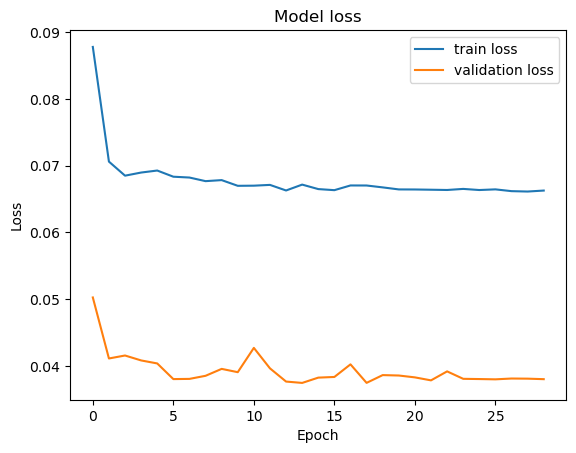

In [6]:
# Plot the training loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [7]:
# Evaluate the model
test_loss, test_mae, test_acc = model.evaluate(test, test_labels_coded)
print('Mean square error:', test_mae)
print('Loss:', test_loss)
print('Accuracy: {:.2f}%'.format(test_acc * 100))

2/2 [==============================] - 0s 121ms/step - loss: 0.0029 - mae: 0.0515 - accuracy: 1.0000
Mean square error: 0.05147816240787506
Loss: 0.0029004786629229784
Accuracy: 100.00%
